### Features
1. Previous Close
2. Previous High
3. Previous Low
4. Previous Open
5. Previous xN OLHC
5. RSI
6. MACD
7. EMA
8. Other time frame OLHC
    - Higher timeframe : add Open
    - Lower timeframe : add OLHC
9. Heikin Ashi
10. Other timeframe HA

### Labels
1. Long / Short 
    - Next candle
    - Next n candle

### Optimization
Optimize EMA window, RSI window

### Important
- Normalization range change, might meet unknown data (use percentage change)
- Current label only for one candle, need use further future for data

In [60]:
import talib
import glob
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import seaborn as sns

from tqdm.notebook import tqdm

## Data Preparation

1. Read data
    - Timeframe
        - 1 day, 4 hour, 1 hour, 15 min
2. Previous n timeframe OLHC
3. Heikin Ashi
    - Previous n timeframe HA OLHC
4. RSI
    - Previous n timeframe RSI
5. Other timeframe data
    - Higher timeframe - Open
    - Lower timeframe - OLHC, HA_OLHC
    - N previous other timeframe data
6. Create Label
    - Use drawdown / runup
    - Close vs High > x %

Drop NA column

Drop 0 volume rows

Drop High, Low, Close

In [299]:
def heikin_ashi(data):
    ha_data = data.copy()
    ha_data['Close'] = (data.Open + data.Low + data.Close + data.High) / 4

    for i in range(data.shape[0]):
        if i > 0:
            ha_data['Open'].iloc[i] = (ha_data.iloc[i-1].Open + ha_data.iloc[i-1].Close) / 2
    ha_data['High'] = ha_data[['High', 'Close', 'Open']].max(axis=1)
    ha_data['Low'] = ha_data[['Low', 'Close', 'Open']].min(axis=1)
    
    return ha_data

In [300]:
data_timeframes = ['1day', '4hour', '1hour', '15min']
df = []

for t in data_timeframes:
    data_paths = glob.glob('data/2022/*/ethusdt.{timeframe}*'.format(timeframe=t))
    
    tmp_df = pd.concat([pd.read_csv(d, index_col='Open time', usecols=['Open time', 'Open', 'High', 'Low', 'Close', 'Volume']) for d in data_paths])
    tmp_df = tmp_df.drop_duplicates(keep='first').dropna()

    tmp_df.index = pd.to_datetime(tmp_df.index)
    tmp_df = tmp_df.sort_values('Open time')
    
    df.append(tmp_df)

In [301]:
data_1day = df[0]
data_4hour = df[1]
data_1hour = df[2]
data_15min = df[3]

In [302]:
# heikin ashi

data_1day_ha = heikin_ashi(df[0])
data_4hour_ha = heikin_ashi(df[1])
data_1hour_ha = heikin_ashi(df[2])
data_15min_ha = heikin_ashi(df[3])

In [303]:
high_open_percent_change = (data_4hour.High - data_4hour.Open) / data_4hour.Open 
low_open_percent_change = (data_4hour.Low - data_4hour.Open) / data_4hour.Open 
close_open_percent_change = (data_4hour.Close - data_4hour.Open) / data_4hour.Open 

high_open_percent_change_ha = (data_4hour_ha.High - data_4hour_ha.Open) / data_4hour_ha.Open 
low_open_percent_change_ha = (data_4hour_ha.Low - data_4hour_ha.Open) / data_4hour_ha.Open 
close_open_percent_change_ha = (data_4hour_ha.Close - data_4hour_ha.Open) / data_4hour_ha.Open 

volume_change1 = data_4hour.Volume.pct_change(periods=1).rename('volume_change1')
volume_change2= data_4hour.Volume.pct_change(periods=2).rename('volume_change2')
volume_change3 = data_4hour.Volume.pct_change(periods=3).rename('volume_change3')

In [304]:
df = pd.concat([high_open_percent_change, low_open_percent_change, close_open_percent_change,
               high_open_percent_change_ha, low_open_percent_change_ha, close_open_percent_change_ha,
               volume_change1, volume_change2, volume_change3], axis=1)
df = df.rename(columns = {0: 'high_open_change', 1: 'low_open_change', 2: 'close_open_change',
                         3: 'high_open_change_ha', 4: 'low_open_change_ha', 5: 'close_open_change_ha'})

In [305]:
# previous n timeframe OLHC

for i in range(1,5):
    df_shift = df.shift(i)

    df['previous{n_shift}_high_open_change'.format(n_shift=i)] = df_shift['high_open_change']
    df['previous{n_shift}_low_open_change'.format(n_shift=i)] = df_shift['low_open_change']
    df['previous{n_shift}_close_open_change'.format(n_shift=i)] = df_shift['close_open_change']

In [306]:
# previous n timeframe OLHC_HA

for i in range(1,5):
    df_ha_shift = df.shift(i)

    df['previous{n_shift}_high_open_change_ha'.format(n_shift=i)] = df_ha_shift['high_open_change_ha']
    df['previous{n_shift}_low_open_change_ha'.format(n_shift=i)] = df_ha_shift['low_open_change_ha']
    df['previous{n_shift}_close_open_change_ha'.format(n_shift=i)] = df_ha_shift['close_open_change_ha']

In [307]:
# # RSI, previous RSI

# data_4hour['rsi'] = talib.RSI(data_4hour.Close, timeperiod=14)

# for i in range(1,5):
#     df_shift = data_4hour.shift(i)
    
#     data_4hour['previous{n_shift}_rsi'.format(n_shift=i)] = df_shift['rsi']

In [308]:
tmp_high_open_percent_change = (data_1hour.High - data_1hour.Open) / data_1hour.Open 
tmp_low_open_percent_change = (data_1hour.Low - data_1hour.Open) / data_1hour.Open 
tmp_close_open_percent_change = (data_1hour.Close - data_1hour.Open) / data_1hour.Open 

tmp_high_open_percent_change_ha = (data_1hour_ha.High - data_1hour_ha.Open) / data_1hour_ha.Open 
tmp_low_open_percent_change_ha = (data_1hour_ha.Low - data_1hour_ha.Open) / data_1hour_ha.Open 
tmp_close_open_percent_change_ha = (data_1hour_ha.Close - data_1hour_ha.Open) / data_1hour_ha.Open 

tmp_volume_change1 = data_1hour.Volume.pct_change(periods=1).rename('volume_change1')
tmp_volume_change2= data_1hour.Volume.pct_change(periods=2).rename('volume_change2')
tmp_volume_change3 = data_1hour.Volume.pct_change(periods=3).rename('volume_change3')

In [309]:
tmp_data_1hour = pd.concat([tmp_high_open_percent_change, tmp_low_open_percent_change, tmp_close_open_percent_change,
               tmp_high_open_percent_change_ha, tmp_low_open_percent_change_ha, tmp_close_open_percent_change_ha,
               tmp_volume_change1, tmp_volume_change2, tmp_volume_change3], axis=1)
tmp_data_1hour = tmp_data_1hour.rename(columns = {0: 'high_open_change', 1: 'low_open_change', 2: 'close_open_change',
                         3: 'high_open_change_ha', 4: 'low_open_change_ha', 5: 'close_open_change_ha'})

In [310]:
tmp_high_open_percent_change = (data_15min.High - data_15min.Open) / data_15min.Open 
tmp_low_open_percent_change = (data_15min.Low - data_15min.Open) / data_15min.Open 
tmp_close_open_percent_change = (data_15min.Close - data_15min.Open) / data_15min.Open 

tmp_high_open_percent_change_ha = (data_15min_ha.High - data_15min_ha.Open) / data_15min_ha.Open 
tmp_low_open_percent_change_ha = (data_15min_ha.Low - data_15min_ha.Open) / data_15min_ha.Open 
tmp_close_open_percent_change_ha = (data_15min_ha.Close - data_15min_ha.Open) / data_15min_ha.Open 

tmp_volume_change1 = data_15min.Volume.pct_change(periods=1).rename('volume_change1')
tmp_volume_change2= data_15min.Volume.pct_change(periods=2).rename('volume_change2')
tmp_volume_change3 = data_15min.Volume.pct_change(periods=3).rename('volume_change3')

In [311]:
tmp_data_15min = pd.concat([tmp_high_open_percent_change, tmp_low_open_percent_change, tmp_close_open_percent_change,
               tmp_high_open_percent_change_ha, tmp_low_open_percent_change_ha, tmp_close_open_percent_change_ha,
               tmp_volume_change1, tmp_volume_change2, tmp_volume_change3], axis=1)
tmp_data_15min = tmp_data_15min.rename(columns = {0: 'high_open_change', 1: 'low_open_change', 2: 'close_open_change',
                         3: 'high_open_change_ha', 4: 'low_open_change_ha', 5: 'close_open_change_ha'})

In [312]:
# Add other timeframe data
# 1. numpy reshape (cannot, some data is missing)
# 2. df filter by index datetime
# 3. df Groupby 

# https://stackoverflow.com/questions/67252385/how-can-i-group-a-pandas-dataframe-by-time-with-a-minimal-amount-of-rows-for-eac
# https://stackoverflow.com/questions/22898824/filtering-pandas-dataframes-on-dates

data_1hour_to_4hour = []
data_15min_to_4hour = []
for i in tqdm(data_4hour.index):
    data_1hour_to_4hour.append(tmp_data_1hour.loc[i - pd.Timedelta(hours=4): i - pd.Timedelta(hours=1)].to_numpy().flatten())
    data_15min_to_4hour.append(tmp_data_15min.loc[i - pd.Timedelta(hours=4): i - pd.Timedelta(minutes=15)].to_numpy().flatten())
data_1hour_to_4hour = pd.DataFrame(data_1hour_to_4hour)
data_15min_to_4hour = pd.DataFrame(data_15min_to_4hour)
    
# a = pd.DataFrame(data=list(map(lambda x: list(x), data_1hour.groupby(pd.Grouper(level='Open time', freq='4h')).apply(lambda x: x.values.flatten()).values)))
# b = pd.DataFrame(data=list(map(lambda x: list(x), data_15min.groupby(pd.Grouper(level='Open time', freq='4h')).apply(lambda x: x.values.flatten()).values)))

  0%|          | 0/1269 [00:00<?, ?it/s]

In [313]:
df = pd.concat([df, data_1hour_to_4hour.set_index(data_4hour.index), data_15min_to_4hour.set_index(data_4hour.index)], axis=1)

In [314]:
# create label

# 0 : ignore
# 1 : long
# 2 : short

percentage_change = ((data_4hour.Close - data_4hour.Open) / data_4hour.Open * 100).values

percentage_change[(percentage_change <= 0.5) & (percentage_change >= -0.5)] = 0
percentage_change[percentage_change > 0.5] = 1
percentage_change[percentage_change < -0.5] = 2

df.loc[:, 'signal'] = percentage_change.astype(int)

In [315]:
df = df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

In [319]:
df = df.drop(columns=['high_open_change', 'low_open_change', 'close_open_change',
       'high_open_change_ha', 'low_open_change_ha', 'close_open_change_ha',
       'volume_change1', 'volume_change2', 'volume_change3'])

## Model

In [320]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import cross_val_score

In [321]:
test_size = 0.2

x = df.drop(columns=['signal']).values
y = df.signal.values

In [322]:
train_size = int(len(x) * (1 - test_size))
test_size = len(x) - train_size

x_train = x[:train_size]
y_train = y[:train_size]

x_test = x[train_size:]
y_test = y[train_size:]

In [323]:
log_reg = LogisticRegression()

In [324]:
log_reg.fit(x_train, y_train)

c:\users\user1\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [325]:
sum(log_reg.predict(x) == y)

547

In [326]:
data_4hour.isnull().sum().any()

False

c:\users\user1\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


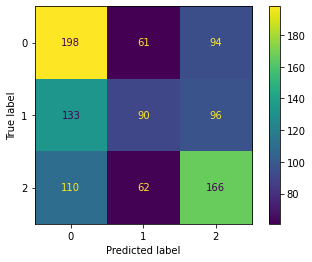

In [327]:
plot_confusion_matrix(log_reg, x_train, y_train)

c:\users\user1\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


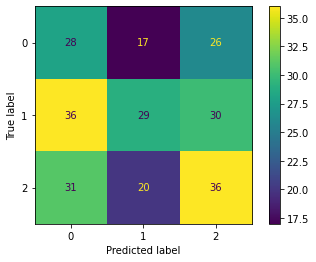

In [328]:
plot_confusion_matrix(log_reg, x_test, y_test)

In [329]:
adaboost = AdaBoostClassifier()

In [330]:
adaboost.fit(x_train, y_train)

AdaBoostClassifier()

In [331]:
cross_val_score(adaboost, x_train, y_train, cv=5)

array([0.35148515, 0.34653465, 0.37128713, 0.42079208, 0.37623762])

c:\users\user1\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


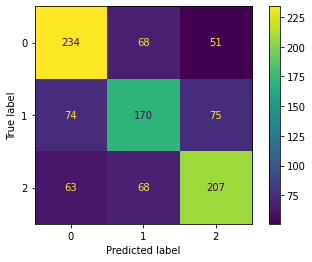

In [332]:
plot_confusion_matrix(adaboost, x_train, y_train)

c:\users\user1\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


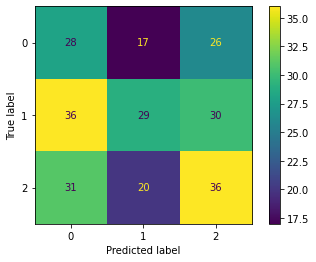

In [333]:
plot_confusion_matrix(log_reg, x_test, y_test)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [ ]:
def train(net, dataloader, criterion, optimizer, device):
    net.train()
    running_loss = 0
    for idx, (x, y) in enumerate(dataloader):
        print('\r{:.2f}%'.format((idx+1) / len(dataloader) * 100), end='')
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        predict = net(x)
        loss = criterion(predict, y)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    return running_loss / len(dataloader)

In [ ]:
def evaluate(net, dataloader, criterion, device):
    net.eval()

    predicts = []
    labels = []
    running_loss = 0
    
    with torch.no_grad():
        for idx, (x, y) in enumerate(dataloader):
            print('\r{:.2f}%'.format((idx+1) / len(dataloader) * 100), end='')

            x = x.to(device)
            y = y.to(device)

            predict = net(x)
            loss = criterion(predict, y)

            predict = F.softmax(predict, dim=1).argmax(axis=1)
            predicts.append(predict.cpu().numpy())
            labels.append(y.cpu().numpy())
            running_loss += loss.item()

    return np.concatenate(predicts), np.concatenate(labels), running_loss / len(dataloader)

## Inference

In [334]:
from Trader import Trader

In [335]:
trader = Trader(account_size=100, leverage=20, fixed_margin=False, margin=0.1)

stoploss = None
rr = 2
tp_ratio = 0.02
tp = None

for idx, x_tmp in df.iloc[-test_size:].drop(columns=['signal']).iterrows():
    d = data_4hour.loc[x_tmp.name]
    signal = log_reg.predict([x_tmp])[0]
    if signal == 2:
        # short
        trader.open_pos(d.Open, 'short', entry_date = idx)
        trader.close_pos(d.Close, exit_date=idx)
        
    elif signal == 1:
        # long
        trader.open_pos(d.Open, 'long', entry_date = idx)
        trader.close_pos(d.Close, exit_date=idx)

    if trader.position != None:
        if trader.is_liquidated(d.Open):
            print('liquidated')
            break

In [336]:
result = pd.DataFrame(trader.history).set_index('entry_date')

win = result[result.percentage > 0]
print('Win rate : {:.2f}%'.format((len(win) / len(result) * 100)))
print('Long win rate : {:.2f}%'.format(len(win[win.position == 'long']) / len(win) * 100))
print('Short win rate : {:.2f}%'.format(len(win[win.position == 'short']) / len(win) * 100))

TP count :  0
SL count :  0
Win rate : 55.06%
Long win rate : 40.23%
Short win rate : 59.77%


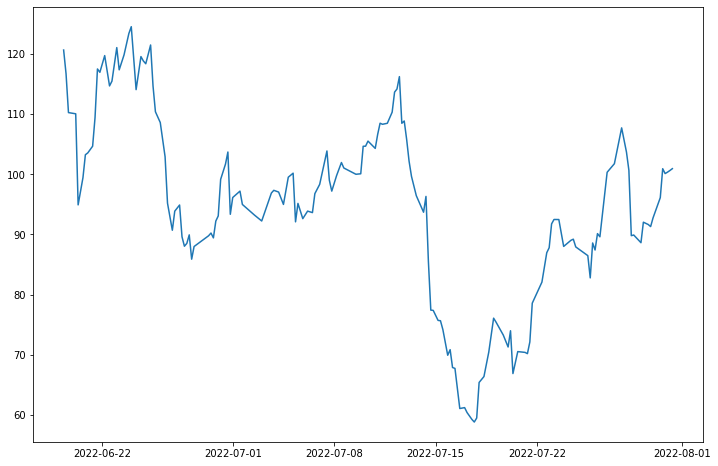

In [337]:
plt.figure(figsize=(12,8))
plt.plot(result.account_size)

In [338]:
result

,entry_price,position,entry_margin,entry_fee,number_contract,exit_price,profit,percentage,exit_fee,account_size,exit_date
entry_date,,,,,,,,,,,
2022-06-19 08:00:00,955.19,long,10.000000,0.080000,0.209382,1054.63,20.820988,2.082099,0.080000,120.660988,2022-06-19 08:00:00
2022-06-19 12:00:00,1054.63,short,12.066099,0.096529,0.228821,1071.06,-3.759537,-0.311578,0.096529,116.708394,2022-06-19 12:00:00
2022-06-19 16:00:00,1071.07,short,11.670839,0.093367,0.217929,1099.81,-6.263268,-0.536660,0.093367,110.258393,2022-06-19 16:00:00
2022-06-20 04:00:00,1079.10,short,11.025839,0.088207,0.204353,1079.21,-0.022479,-0.002039,0.088207,110.059501,2022-06-20 04:00:00
2022-06-20 08:00:00,1079.22,short,11.005950,0.088048,0.203961,1152.59,-14.964633,-1.359686,0.088048,94.918773,2022-06-20 08:00:00
...,...,...,...,...,...,...,...,...,...,...,...
2022-07-30 16:00:00,1736.08,short,9.612166,0.076897,0.110734,1691.25,4.964211,0.516451,0.076897,100.932077,2022-07-30 16:00:00
2022-07-30 20:00:00,1691.25,short,10.093208,0.080746,0.119358,1696.68,-0.648114,-0.064213,0.080746,100.122472,2022-07-30 20:00:00
2022-07-31 00:00:00,1696.68,short,10.012247,0.080098,0.118022,1693.30,0.398913,0.039843,0.080098,100.361189,2022-07-31 00:00:00


In [339]:
data_4hour.loc[result.index]

,Open,High,Low,Close,Volume
entry_date,,,,,
2022-06-19 08:00:00,955.19,1080.67,951.98,1054.63,2471637.172
2022-06-19 12:00:00,1054.63,1079.20,1017.50,1071.06,1738780.526
2022-06-19 16:00:00,1071.07,1131.54,1042.17,1099.81,1486709.221
2022-06-20 04:00:00,1079.10,1093.00,1059.70,1079.21,1026475.427
2022-06-20 08:00:00,1079.22,1174.00,1076.24,1152.59,2119796.928
...,...,...,...,...,...
2022-07-30 16:00:00,1736.08,1737.10,1688.24,1691.25,677687.396
2022-07-30 20:00:00,1691.25,1708.30,1671.00,1696.68,841498.845
2022-07-31 00:00:00,1696.68,1715.09,1685.80,1693.30,580817.975
